In [1]:
#%pip install mlxtend --upgrade
%pip install pyLDAvis
%pip install surprise
#%pip install tqdm
# %pip install ipywidgets

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.1.tar.gz (11.8 MB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1626194 sha256=7fe92b3bb981f5f116a9d96de424e1617dee5861349af361745e2ad9b9f617fa
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# Imports

In [2]:
import os
import pandas as pd
import numpy as np

from imblearn.over_sampling import ADASYN, SMOTE

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate,Embedding,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()

from sklearn.metrics import plot_confusion_matrix,classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import cohen_kappa_score

from sklearn.preprocessing import Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.cluster import KElbowVisualizer

import xgboost as xgb

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import string


from gensim import matutils, models
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import gensim


import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import plotly.express as px

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SVDpp

from sklearn.decomposition import NMF as NMF_sklearn
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Read data and initialize variables

In [3]:
RANDOM_STATE=0
movies_metadata="https://raw.githubusercontent.com/ahmed2m/DataScience-Applications-DTI5125/main/movies_metadata.csv?token=AGKLTOMJPX3FHLGZ2FMHGCLBWO2XG"
ratings_small=""

In [4]:
df= pd.read_csv(
    movies_metadata
    )

df=df.sample(len(df), random_state=RANDOM_STATE)

In [5]:
columns_text=["original_title","overview","tagline"]

columns_to_use=["adult","budget","original_language","popularity",
                "revenue","vote_average","vote_count"]
column_target=["genres_list","genre_hot_encoded"]

In [6]:
# column encoder
def encoder(column_df):
    enc = LabelEncoder()
    return enc.fit_transform(df[column_df]), enc.classes_

In [7]:
# onehotencoding method #2 for list(dict) column types
def one_hot_dict_converter(column_df):
    global df
    tmp_column_list=[]
    index_del=[]
    for index, i in enumerate(df[column_df]):
        tmp=[]
        try:
            for j in eval(i):
                tmp.append(j["name"])
        except:
            index_del.append(index)
            print(f"error in {index} {i} {j}")
        tmp_column_list.append(tmp)

    # check record length , and delete record from dataframe is there is error and the updated 
    # multilabelBinarizers will retrun each to the adjacent correct index number
    df=df.drop(df.index[index_del])
    df.reset_index(drop=True,inplace=True)
    
    mlb = MultiLabelBinarizer()
    new_features = mlb.fit_transform(tmp_column_list)
    return new_features

In [8]:
def clean_text(text):
    '''
    - Make text lowercase
    - Remove text in square brackets
    - Remove punctuation
    - Remove words containing numbers
    - Match words only not in stop words
    - Remove empty strings
    - Get rid of some additional punctuation
    - Get rid of some non-sensical text
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text_words = list(filter(lambda x: x not in stopwords.words("english"), re.findall("[\w]*", text)))
    text_words = list(filter(lambda x: x != '', text_words)) # I think this is line is doing nothing @ansary check and delete plz XD
    text = ' '.join(text_words)
    return text

# Data preprocessing

In [9]:
# remove extra wrong records in adult and original language columns
df = df.loc[df["adult"].isin(["True","False"])]
df = df[df["original_language"].notna()]

#generating list of genres per record and replace empty genres with empty string
final_genre_list=[]
for i in df["genres"]:
    tmp=[]
    for j in eval(i):
        tmp.append(j["name"])
    final_genre_list.append(tmp)

df["genres_list"]=final_genre_list
df["genres_list"].replace({"[]": ""}, inplace=True)

df.reset_index(drop=True,inplace=True)

In [10]:
#unique genres
unique_genres=np.unique(list(np.concatenate(final_genre_list).flat))

In [11]:
# one_hot_encoder for final_genre_list 
hot_encoded_genres=[]
enc = LabelEncoder()
enc.fit(unique_genres)

for i in final_genre_list:
    letters= [0 for _ in range(len(unique_genres))]
    for j in enc.transform(i):
        letters[j]=1
    hot_encoded_genres.append(letters)

df["genre_hot_encoded"]=hot_encoded_genres

In [12]:
df["adult"], _= encoder("adult")
df["original_language"], original_language_classes = encoder("original_language")

In [13]:
X = df.loc[:,columns_to_use+columns_text+column_target]
del df

In [14]:
# encoding genres list to 0,1,2,3,..368
genre_list_enc = LabelEncoder()
X["genres_list_encoded"]=genre_list_enc.fit_transform(X["genres_list"].astype(str))

In [15]:
X["genres_list_tupled"] = list(tuple(sorted(x)) for x in X["genres_list"])
X=X[X["genres_list_tupled"]!=()]

In [16]:
X= X[X['overview'].notna()]
X["tagline"]=X["tagline"].replace(np.NAN,"")

# load the last cleaned overiew data as it take too much time , we didn't remove notna above it for length consistency , it should be the same as saved before
try:
  X["overview"]=pd.read_csv("overview.csv")["overview"]
except:
  print("creating new csv file for overview column")
  X["overview"]=X["overview"].apply(lambda x:clean_text(x))
  X["overview"].to_csv("overview.csv")

creating new csv file for overview column


In [17]:
genre_tupled_sorted=pd.DataFrame([
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[0]),
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[1])
                                  ]).T.sort_values(by=1, ascending=False)
genre_tupled_sorted=genre_tupled_sorted.rename(columns={0: "genre_tuples", 1: "count"})
genre_tupled_sorted

,genre_tuples,count
1528,"(Drama,)",4910
1082,"(Comedy,)",3371
1468,"(Documentary,)",2682
1709,"(Drama, Romance)",1627
1150,"(Comedy, Drama)",1619
...,...,...
829,"(Adventure, Drama, Family, Science Fiction, TV...",1
827,"(Adventure, Drama, Family, Romance)",1
825,"(Adventure, Drama, Family, Foreign)",1
824,"(Adventure, Drama, Family, Fantasy, Thriller)",1


In [18]:
X.reset_index(inplace=True,drop=True)

In [19]:
X= X[X["popularity"].notna()]
X= X[X["vote_count"].notna()]
X= X[X["revenue"].notna()]

In [20]:
X=X.astype({'budget': 'int32','popularity': 'float32','vote_count':'int32','revenue': 'int32'})

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42312 entries, 0 to 42314
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   adult                42312 non-null  int64  
 1   budget               42312 non-null  int32  
 2   original_language    42312 non-null  int64  
 3   popularity           42312 non-null  float32
 4   revenue              42312 non-null  int32  
 5   vote_average         42312 non-null  float64
 6   vote_count           42312 non-null  int32  
 7   original_title       42312 non-null  object 
 8   overview             42312 non-null  object 
 9   tagline              42312 non-null  object 
 10  genres_list          42312 non-null  object 
 11  genre_hot_encoded    42312 non-null  object 
 12  genres_list_encoded  42312 non-null  int64  
 13  genres_list_tupled   42312 non-null  object 
dtypes: float32(1), float64(1), int32(3), int64(3), object(6)
memory usage: 4.2+ MB


In [22]:
X.describe()

,adult,budget,original_language,popularity,revenue,vote_average,vote_count,genres_list_encoded
count,42312.000000,4.231200e+04,42312.000000,42312.000000,4.231200e+04,42312.000000,42312.000000,42312.000000
mean,0.000213,4.532266e+06,22.416312,3.110191,1.192038e+07,5.711318,117.727359,2011.555989
std,0.014583,1.802132e+07,14.040875,6.180851,6.606338e+07,1.785642,508.372330,927.599828
min,0.000000,0.000000e+00,0.000000,0.000000,-2.147484e+09,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,17.000000,0.465284,0.000000e+00,5.100000,4.000000,1507.000000
50%,0.000000,0.000000e+00,17.000000,1.260372,0.000000e+00,6.000000,11.000000,1935.000000
75%,0.000000,0.000000e+00,17.000000,4.126994,0.000000e+00,6.800000,38.000000,2383.000000
max,1.000000,3.800000e+08,88.000000,547.488281,2.068224e+09,10.000000,14075.000000,4063.000000


In [23]:
# updating revenue column to make it all positive as there is cells with negative vaue which is not realsitic
X["revenue"]=X["revenue"].apply(lambda x:abs(x))

In [24]:

X["tagline"]=X["tagline"].apply(lambda x:clean_text(x))

X["text_concat"]=X["original_title"]+" "+X["overview"]+" "+X["tagline"]
X=X[X["text_concat"].notna()]

# visulaizations

#### As we see below we have imbalance classes


In [25]:
top=80

Total count of unqiue tupled genres is : 1910


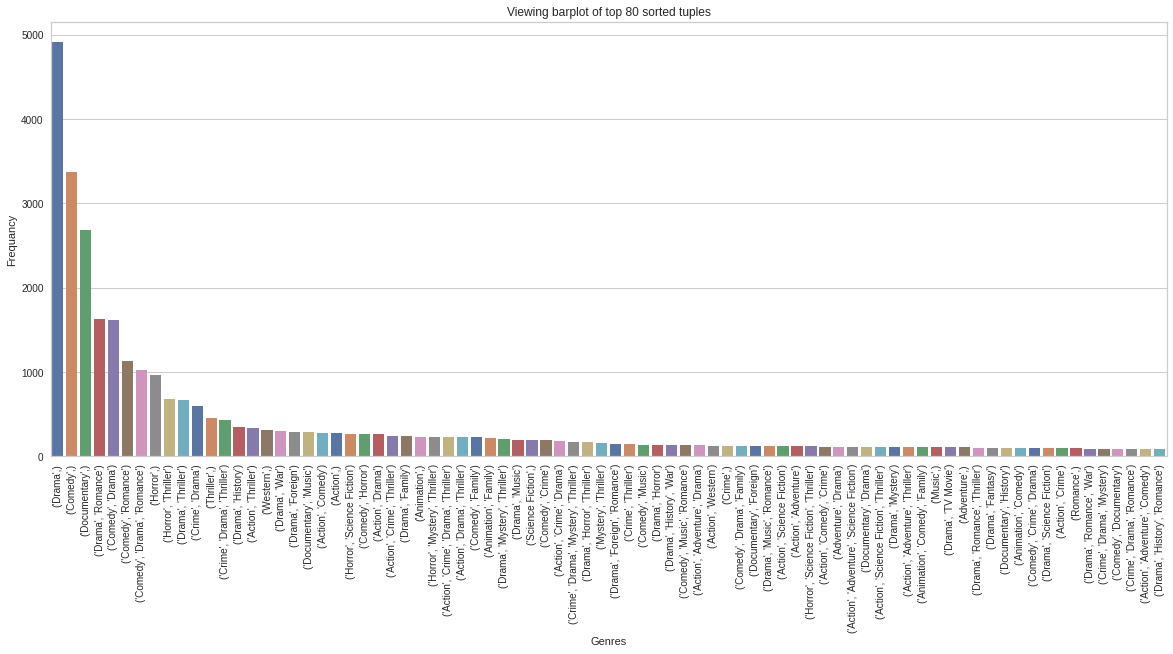

In [26]:
# top genre tupled histogram
print("Total count of unqiue tupled genres is :",len(genre_tupled_sorted))


plt.figure(figsize=(20,8))
plt.title(f"Viewing barplot of top {top} sorted tuples")
plt.xticks(rotation=90)
ax = sns.barplot(x="genre_tuples", y="count", data=genre_tupled_sorted.iloc[0:top,:],palette="deep")
ax.set(xlabel='Genres', ylabel='Frequancy')
plt.show()

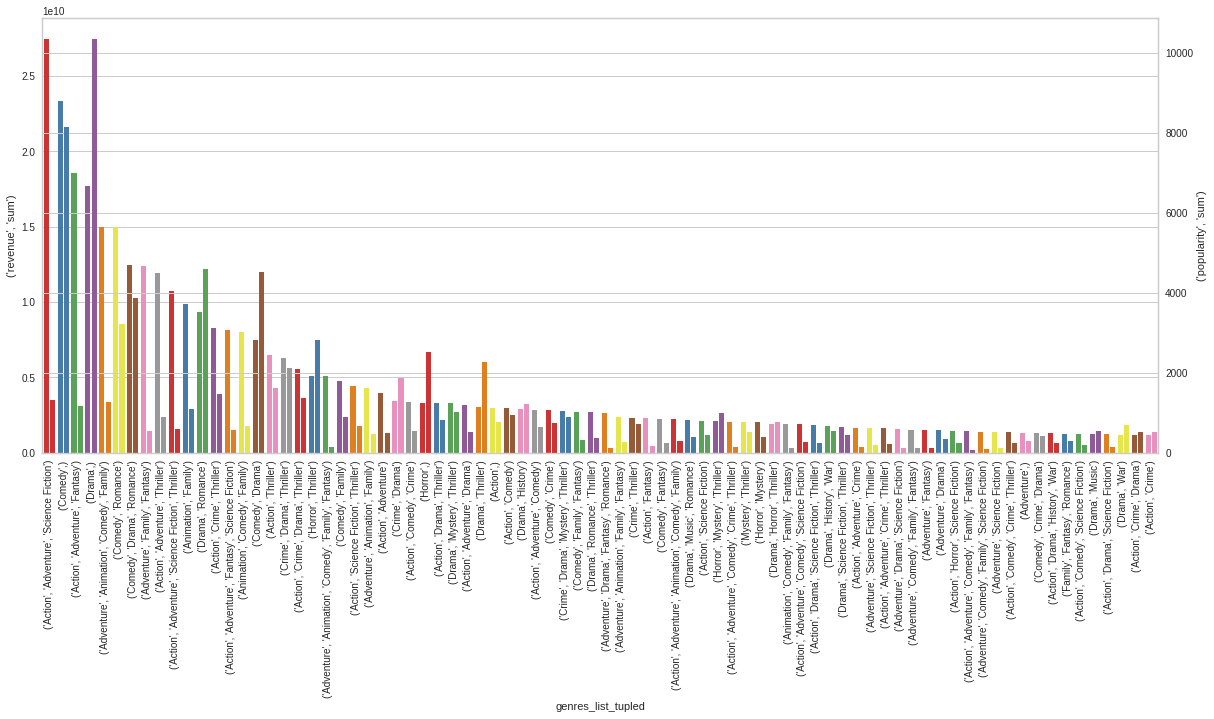

In [27]:
fig = plt.figure(figsize=(20,8))
plt.xticks(rotation=90)


ax = sns.barplot(x="genres_list_tupled", y=("revenue","sum"),
            data=X.groupby(['genres_list_tupled'])["revenue","popularity"]
                    .agg({"revenue":["sum"],"popularity":["sum"]})
                    .reset_index()
                    .sort_values(by=("revenue","sum"),ascending=False)
                    .iloc[0:top,:],
            palette="Set1")

ax2 = ax.twinx()
g2 = sns.barplot(x="genres_list_tupled", y=("popularity","sum"),
            data=X.groupby(['genres_list_tupled'])["revenue","popularity"]
                    .agg({"revenue":["sum"],"popularity":["sum"]})
                    .reset_index()
                    .sort_values(by=("revenue","sum"),ascending=False)
                    .iloc[0:top,:],
            palette="Set1",ax=ax2)

width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)


for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)

plt.show()


#ax.set(xlabel='Genres', ylabel='Revenue in billion')
#plt.show()

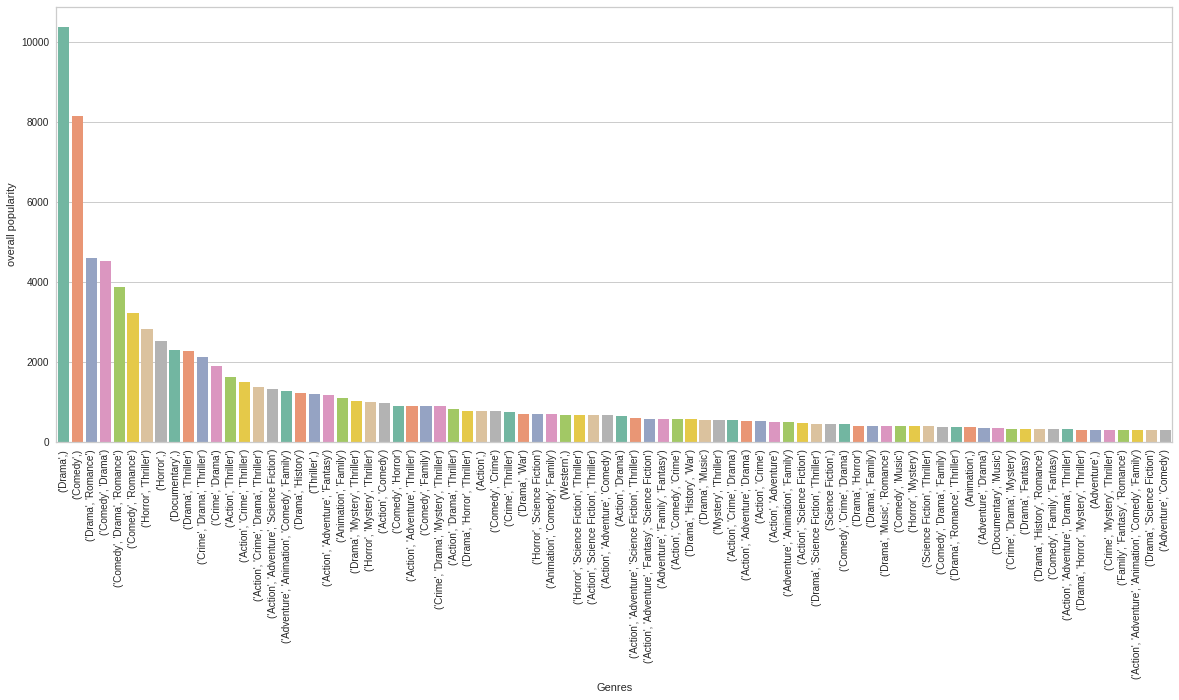

In [28]:
# genre vs overall popularity
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

ax = sns.barplot(x="genres_list_tupled", y="sum",
            data=X.groupby(['genres_list_tupled'])["popularity"]
            .agg(['sum'])
            .reset_index()
            .sort_values(by="sum",ascending=False).iloc[0:top,:],palette="Set2")

ax.set(xlabel='Genres', ylabel='overall popularity')
plt.show()

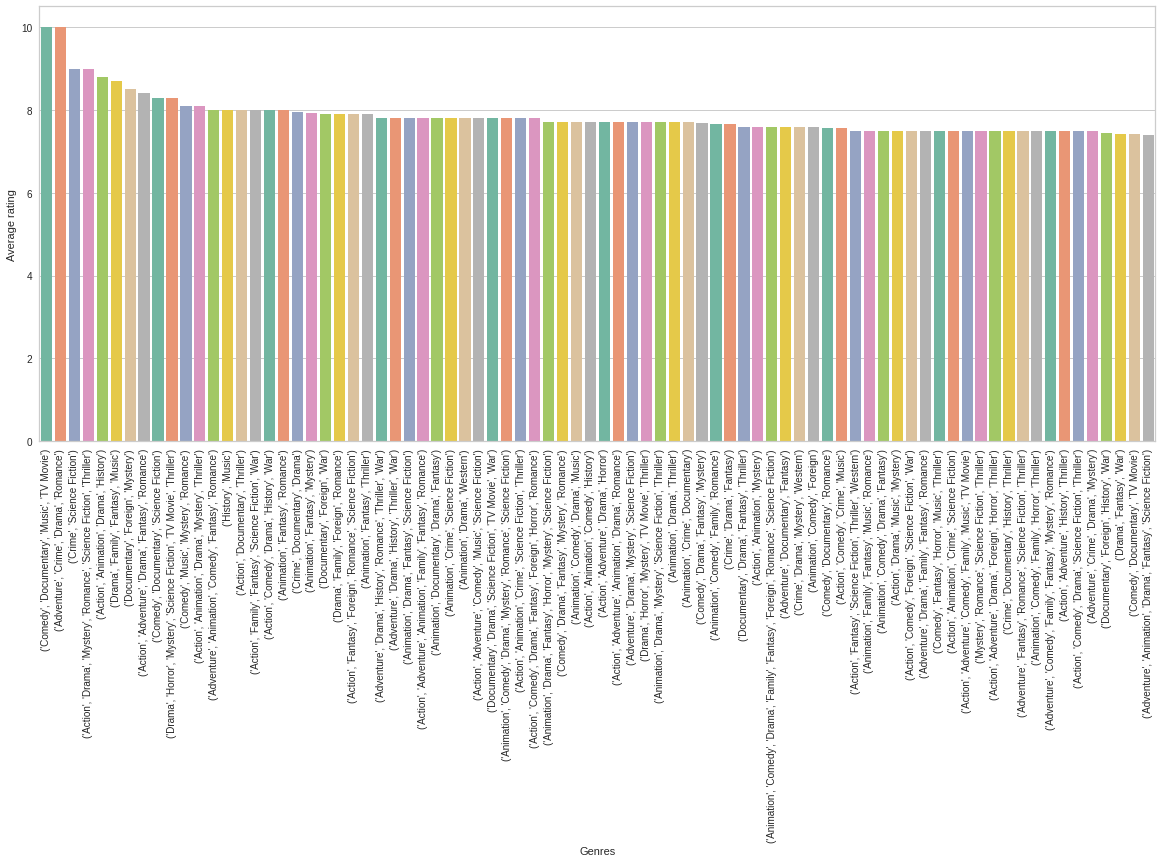

In [29]:
# here we only got avergae rating vs genres without taking into consideration
# number of voters as we see in next cell the one with rating 10.0 has only one voter
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

ax = sns.barplot(x="genres_list_tupled", y=("vote_average","mean"),
            data=X.groupby(['genres_list_tupled'])["vote_average","vote_count"].agg(['mean',"sum"]).reset_index().sort_values(by=("vote_average","mean"),ascending=False).iloc[0:top,:],palette="Set2")

ax.set(xlabel='Genres', ylabel='Average rating')
plt.show()

In [30]:
# only one voter as we see from the data
print("('Comedy','Documentary','Music','TV Movie') has only",len(X[X["genres_list_tupled"]==('Comedy','Documentary','Music','TV Movie')]),"vote/s")

print("('Adventure','Crime','Drama','Romance') has only",len(X[X["genres_list_tupled"]==('Adventure','Crime','Drama','Romance')]),"vote/s")

('Comedy','Documentary','Music','TV Movie') has only 1 vote/s
('Adventure','Crime','Drama','Romance') has only 1 vote/s


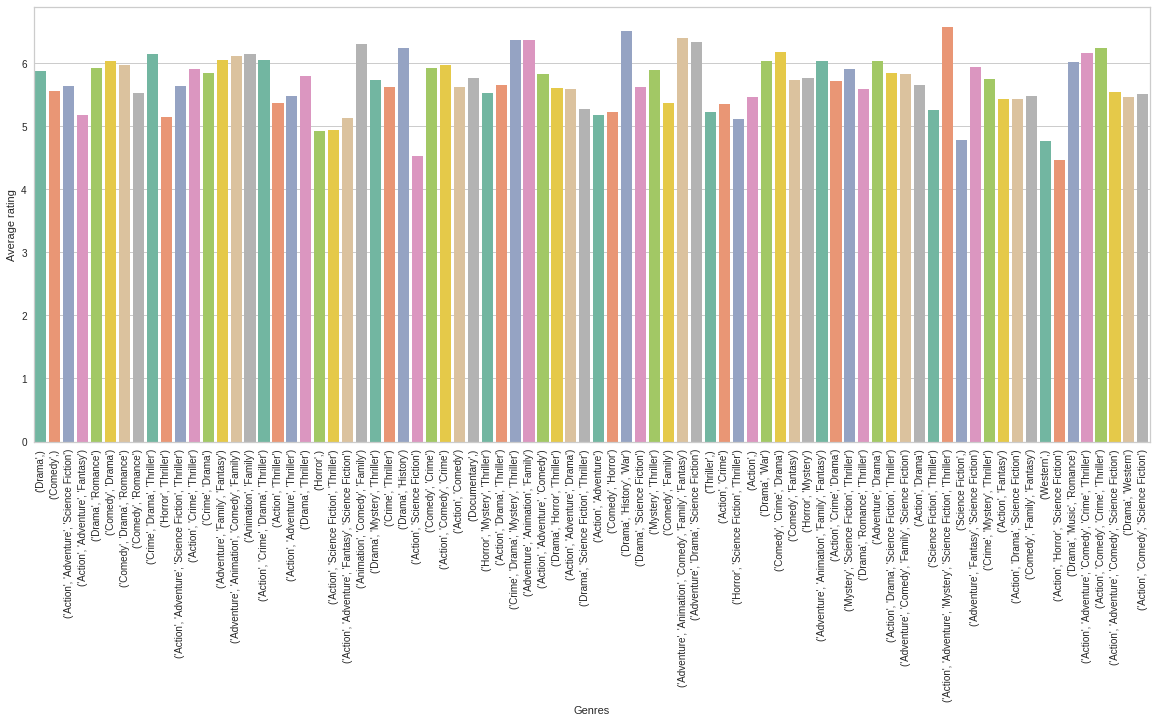

In [31]:
# here we plotted Genres vs average voting sorted with number of voters
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

ax = sns.barplot(x="genres_list_tupled", y=('vote_average', 'mean'),
            data=X.groupby(['genres_list_tupled'],as_index=False)["vote_average","vote_count"]
            .agg({'vote_average' : ['mean'], 'vote_count' : ['sum']})
            .sort_values([('vote_count',  'sum'),('vote_average', 'mean')],ascending=False)
            .iloc[0:top,:]
            ,palette="Set2")


ax.set(xlabel='Genres', ylabel='Average rating')
plt.show()

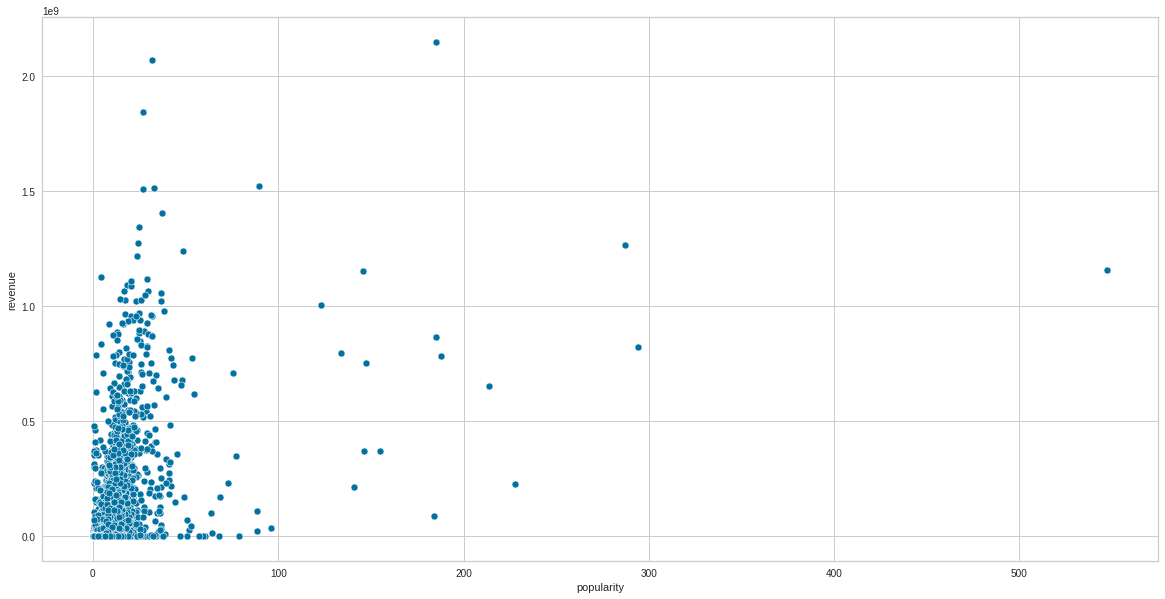

In [32]:
# popularity vs revenue
plt.figure(figsize=(20,10))
sns.scatterplot(data=X, x="popularity", y="revenue")

In [33]:
# data preparation -> new column for average votes for next visyalzation (vote_count vs revenue vs vote_average)
X["vote_average_categorical"]=X["vote_average"].apply(lambda x: "Good" if x>7 else "Bad")

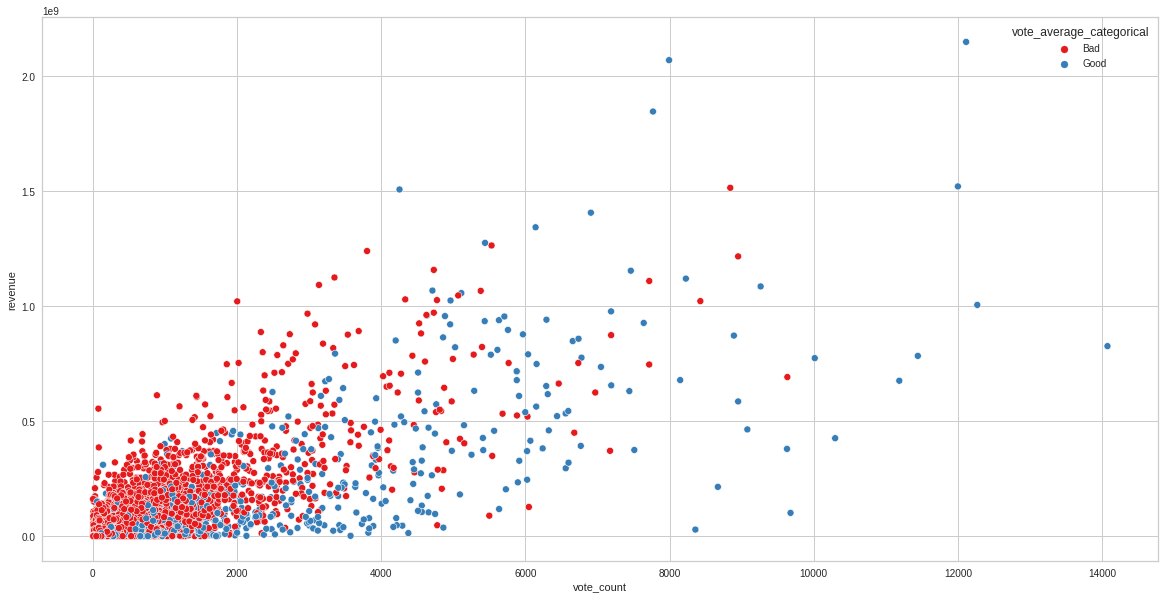

In [34]:
# vote_count vs revenue
plt.figure(figsize=(20,10))
sns.scatterplot(data=X, x="vote_count", y="revenue",hue="vote_average_categorical",palette="Set1")

In [35]:
# most common genre across all dataset

from collections import Counter

words = X["genres_list"].to_list()
counter = Counter(words[0])
for i in words[1:]: 
    counter.update(i)

counter.most_common()

[('Drama', 20020),
 ('Comedy', 12805),
 ('Thriller', 7585),
 ('Romance', 6672),
 ('Action', 6562),
 ('Horror', 4659),
 ('Crime', 4269),
 ('Documentary', 3882),
 ('Adventure', 3470),
 ('Science Fiction', 3026),
 ('Family', 2732),
 ('Mystery', 2451),
 ('Fantasy', 2290),
 ('Animation', 1917),
 ('Foreign', 1599),
 ('Music', 1588),
 ('History', 1378),
 ('War', 1308),
 ('Western', 1034),
 ('TV Movie', 750)]

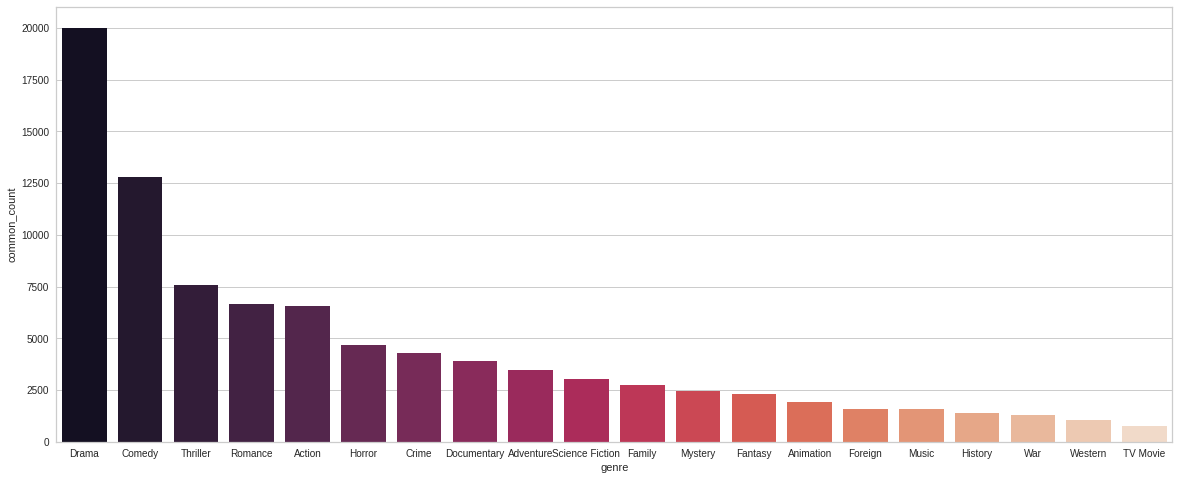

In [36]:
# most common genre in all the dataset
plt.figure(figsize=(20,8))

sns.barplot(data=pd.DataFrame(counter.most_common()).rename(columns={0:"genre",1:"common_count"}),
            x="genre",y="common_count",palette="rocket")


In [37]:
numeric_columns=[]
for i in X.columns:
    if "int" in str(X[i].dtype) or "float" in str(X[i].dtype):
        numeric_columns.append(i)
numeric_columns=numeric_columns[1:]

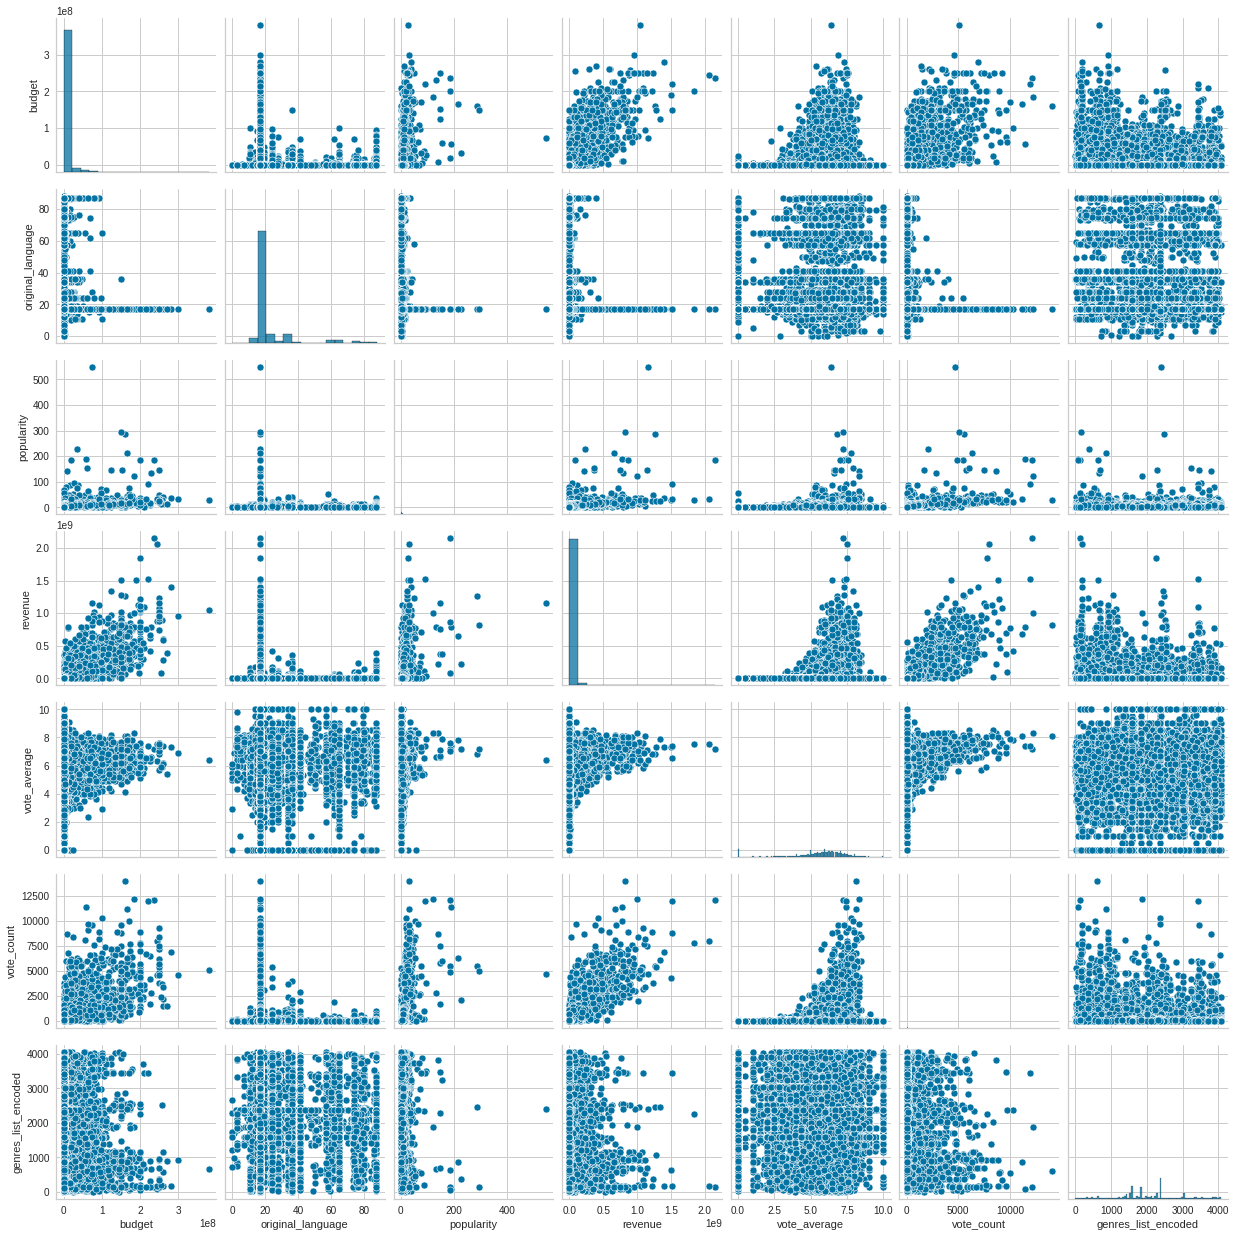

In [38]:
# heatmap
sns.pairplot(X.loc[:,numeric_columns])
plt.show()

In [39]:
# Heatmap corr attempt

# plt.figure(figsize=(20,8))
# sns.heatmap(X.loc[:,numeric_columns])

In [40]:
# remove minor classes with certain threshold to make data more balanced
X=X[X["genres_list_tupled"].isin(list(genre_tupled_sorted.iloc[:7,:]["genre_tuples"].values))]
X.reset_index(inplace=True, drop=True)
X_full = X.copy()
len(X)

16362

In [41]:
genre_tupled_sorted=pd.DataFrame([
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[0]),
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[1])
                                  ]).T.sort_values(by=1, ascending=False)
genre_tupled_sorted=genre_tupled_sorted.rename(columns={0: "genre_tuples", 1: "count"})
genre_tupled_sorted

,genre_tuples,count
5,"(Drama,)",4910
0,"(Comedy,)",3371
4,"(Documentary,)",2682
6,"(Drama, Romance)",1627
1,"(Comedy, Drama)",1619
3,"(Comedy, Romance)",1128
2,"(Comedy, Drama, Romance)",1025


Total count of unqiue tupled genres is : 7


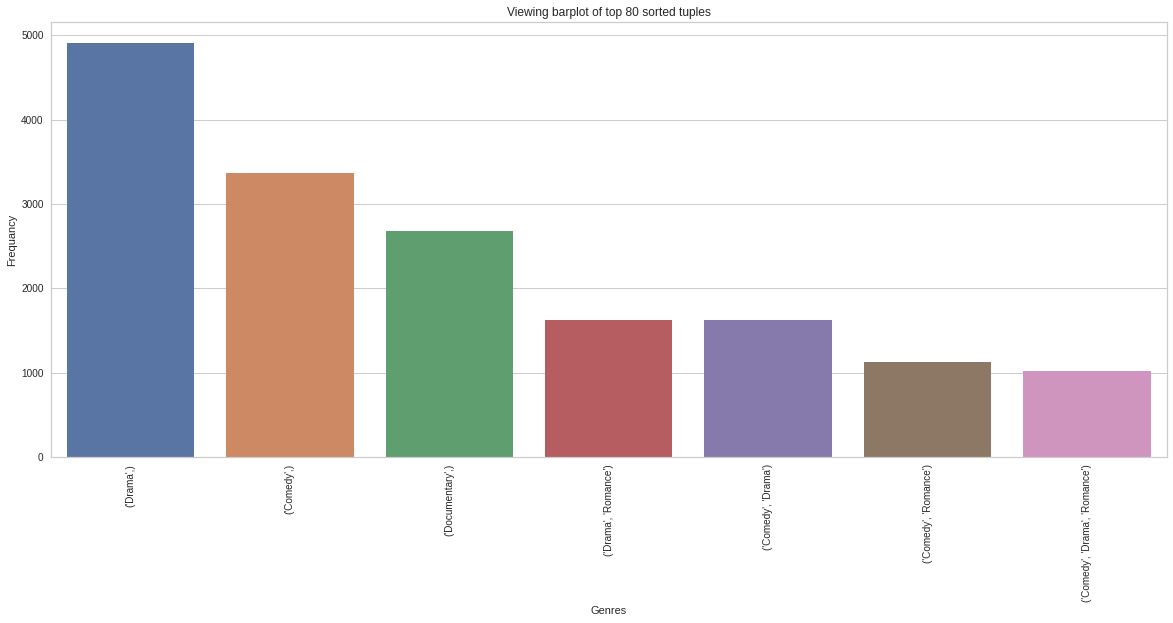

In [42]:
# top genre tupled histogram AFTER threshold
print("Total count of unqiue tupled genres is :",len(genre_tupled_sorted))


plt.figure(figsize=(20,8))
plt.title(f"Viewing barplot of top {top} sorted tuples")
plt.xticks(rotation=90)
ax = sns.barplot(x="genre_tuples", y="count", data=genre_tupled_sorted.iloc[0:top,:],palette="deep")
ax.set(xlabel='Genres', ylabel='Frequancy')
plt.show()

In [43]:
#generating list of genres per record and replace empty genres with empty string
final_genre_list=[]
for i in X["genres_list"]:
    final_genre_list.append(i)

#unique genres
unique_genres=np.unique(list(np.concatenate(final_genre_list).flat))
print("unique genres :",len(unique_genres))

unique genres : 4


In [44]:
# for the full data withoud the threshold 
#generating list of genres per record and replace empty genres with empty string
full_final_genre_list=[]
for i in X_full["genres_list"]:
    full_final_genre_list.append(i)

#unique genres
full_unique_genres=np.unique(list(np.concatenate(full_final_genre_list).flat))
print("unique genres :",len(full_unique_genres))

unique genres : 4


In [45]:
unique_genres

array(['Comedy', 'Documentary', 'Drama', 'Romance'], dtype='<U11')

In [46]:
full_unique_genres

array(['Comedy', 'Documentary', 'Drama', 'Romance'], dtype='<U11')

In [47]:
#SMOTE(random_state=rs)
#ADASYN(random_state=RANDOM_STATE).fit_resample(trX, trY)

In [48]:
def generate_hot_encoded_genres(genre_list, unique_genres):
    hot_encoded_genres=[]
    enc = LabelEncoder()
    enc.fit(unique_genres)

    for i in final_genre_list:
        letters= [0 for _ in range(len(unique_genres))]
        for j in enc.transform(i):
            letters[j]=1
        hot_encoded_genres.append(letters)
    return hot_encoded_genres

In [49]:
# one_hot_encoder for final_genre_list 
X["genre_hot_encoded"]= generate_hot_encoded_genres(final_genre_list, unique_genres)

In [50]:
X_full["genre_hot_encoded"]= generate_hot_encoded_genres(full_unique_genres, full_unique_genres)

# oversampling the data


# bow 

In [51]:
# train test split
train_split=0.80

X=X.sample(len(X))
X.reset_index(drop=True,inplace=True)

X_train=X.iloc[0:int(len(X)*train_split),:]
X_train.reset_index(drop=True,inplace=True)

X_test=X.iloc[int(len(X)*train_split):,:]
X_test.reset_index(drop=True,inplace=True)

In [52]:
# count vectorizer

count_vectorizer = CountVectorizer() # Convert a collection of text documents to a matrix of token counts
count_vectorizer.fit(X_train["text_concat"])

X_bow_train_old = count_vectorizer.transform(X_train["text_concat"])
X_bow_test_old = count_vectorizer.transform(X_test["text_concat"])

In [53]:
# pca dimensiolity reduction for the data
print(f"previous output of X_bow dimensions is {X_bow_train_old.shape}")

svd=TruncatedSVD(n_components=10)
svd.fit(X_bow_train_old)

X_bow_train = svd.transform(X_bow_train_old)
X_bow_test = svd.transform(X_bow_test_old)

print(f"New output of X_bow dimensions is {X_bow_train.shape}")



previous output of X_bow dimensions is (13089, 53573)
New output of X_bow dimensions is (13089, 10)


# KMEANS

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
Sum_of_squared_distances=[]
n=20
for i in range(2,n):
    kmeans = KMeans(n_clusters=int(i), random_state=RANDOM_STATE).fit(X_full.loc[:,columns_to_use])
    Sum_of_squared_distances.append(kmeans.inertia_)

#kmeans.predict([[0, 0], [12, 3]])

#kmeans.cluster_centers_


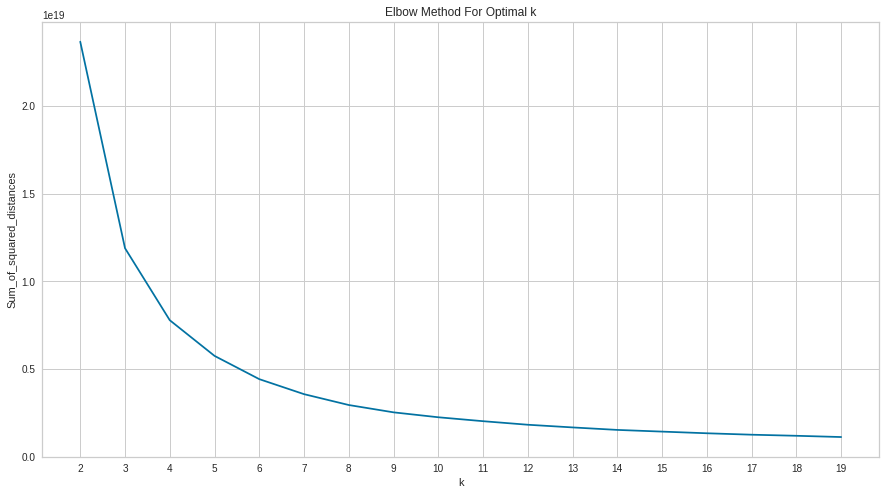

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(2,n), Sum_of_squared_distances, 'bx-')
plt.xticks(range(2,n),range(2,n))
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# yellow brick elbow

In [ ]:
X_full.isnull().sum()

adult                  0
budget                 0
original_language      0
popularity             0
revenue                0
vote_average           0
vote_count             0
original_title         0
overview               0
tagline                0
genres_list            0
genre_hot_encoded      0
genres_list_encoded    0
genres_list_tupled     0
text_concat            0
dtype: int64

In [ ]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12702 entries, 0 to 12703
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   adult                12702 non-null  int64  
 1   budget               12702 non-null  int32  
 2   original_language    12702 non-null  int64  
 3   popularity           12702 non-null  float32
 4   revenue              12702 non-null  int64  
 5   vote_average         12702 non-null  float64
 6   vote_count           12702 non-null  int32  
 7   original_title       12702 non-null  object 
 8   overview             12702 non-null  object 
 9   tagline              12702 non-null  object 
 10  genres_list          12702 non-null  object 
 11  genre_hot_encoded    12702 non-null  object 
 12  genres_list_encoded  12702 non-null  int64  
 13  genres_list_tupled   12702 non-null  object 
 14  text_concat          12702 non-null  object 
dtypes: float32(1), float64(1), int32(2),

In [ ]:
X.describe()

,adult,budget,original_language,popularity,revenue,vote_average,vote_count,genres_list_encoded
count,42312.000000,4.231200e+04,42312.000000,42312.000000,4.231200e+04,42312.000000,42312.000000,42312.000000
mean,0.000213,4.532266e+06,22.416312,3.110186,1.202189e+07,5.711318,117.727359,2011.555989
std,0.014583,1.802132e+07,14.040875,6.180855,6.604499e+07,1.785642,508.372330,927.599828
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,17.000000,0.465284,0.000000e+00,5.100000,4.000000,1507.000000
50%,0.000000,0.000000e+00,17.000000,1.260372,0.000000e+00,6.000000,11.000000,1935.000000
75%,0.000000,0.000000e+00,17.000000,4.126994,0.000000e+00,6.800000,38.000000,2383.000000
max,1.000000,3.800000e+08,88.000000,547.488281,2.147484e+09,10.000000,14075.000000,4063.000000


In [ ]:
X.head()

,adult,budget,original_language,popularity,revenue,vote_average,vote_count,original_title,overview,tagline,genres_list,genre_hot_encoded,genres_list_encoded,genres_list_tupled,text_concat,vote_average_categorical
0,0,0,17,1.202655,0,6.1,16,Sgt. Kabukiman N.Y.P.D.,harry griswald nypd cop possessed spirit great...,fatal sushi lethal chopsticks american apple pie,"[Action, Comedy, Fantasy]","[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",284,"(Action, Comedy, Fantasy)",Sgt. Kabukiman N.Y.P.D. harry griswald nypd co...,Bad
1,0,3000000,17,4.783203,0,6.6,113,Inferno,young man returns rome sisters satanic new yor...,tenebrae beyond suspiria inferno,"[Horror, Thriller]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",3027,"(Horror, Thriller)",Inferno young man returns rome sisters satanic...,Bad
2,0,0,17,1.764311,0,6.0,12,Duo shuai,midst violent gang war series misfortunes thre...,one bad movekills,"[Action, Crime]","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",369,"(Action, Crime)",Duo shuai midst violent gang war series misfor...,Bad
3,0,0,17,4.334953,0,7.4,52,Gasland,happening across americarural landowners wake ...,light water fire,[Documentary],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1844,"(Documentary,)",Gasland happening across americarural landowne...,Good
4,0,0,17,0.975404,0,3.7,3,Sensation,manboy farmer donal discovers father suddenly ...,,"[Drama, Comedy, Romance, Foreign]","[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...",1975,"(Comedy, Drama, Foreign, Romance)",Sensation manboy farmer donal discovers father...,Bad


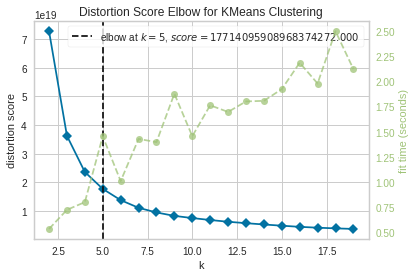

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,20))

visualizer.fit(X.loc[:,columns_to_use])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# wordcloud

In [ ]:
#visualizer.elbow_value_
num_clusters=6
kmeans_bow = KMeans(
    n_clusters=num_clusters,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)
kmeans_bow.fit(X_bow_train_old)
y_pred_bow = kmeans_bow.fit_predict(X_bow_train_old)

centroids_bow = kmeans_bow.cluster_centers_.argsort()[:, ::-1]
terms_bow = count_vectorizer.get_feature_names()

#print(pd.DataFrame(y_pred_bow))
#print(centroids_bow)
#print(terms_bow)

# print('Silhouette Score BoW:', silhouette_score(X_bow[:].todense(), y_pred_bow, metric='euclidean'))
# kmeans_silhouette_scores.append(silhouette_score(X_bow[:].todense(), y_pred_bow, metric='euclidean'))
# print('Kappa Score BoW:', cohen_kappa_score(y_pred_bow, y_encoded))
# kmeans_kappa_scores.append(cohen_kappa_score(y_pred_bow, y_encoded))
# kmeans_titles.append('KMeans with BoW')

In [ ]:
centroids_bow = kmeans_bow.cluster_centers_.argsort()[:, ::-1]

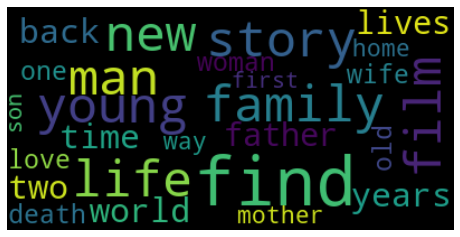

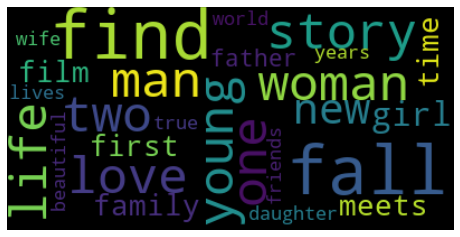

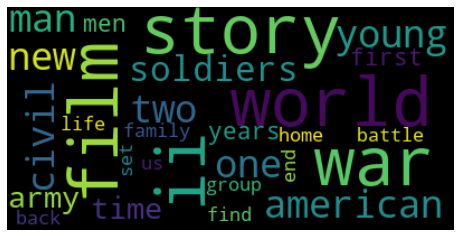

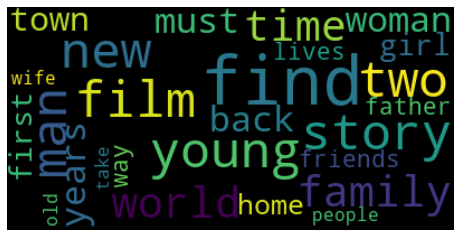

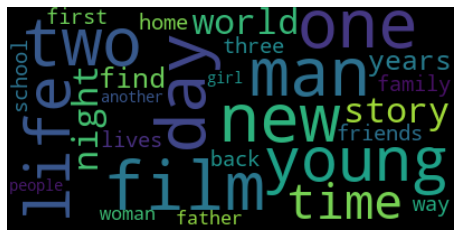

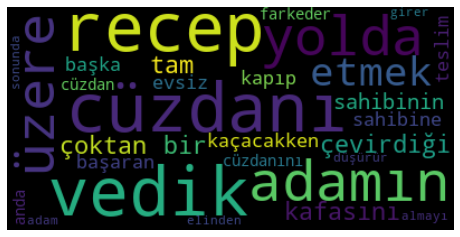

In [ ]:
# WordCloud
clusters = []
for i in range(num_clusters):
    cluster = []
    for ind in centroids_bow[i, :30]:
        cluster.append(terms_bow[ind])
    #print(cluster)
    clusters.append(' '.join(str(''.join(str(x) for x in v)) for v in cluster))


for i in range(len(clusters)):
    cluster_words = "".join(str(x) for x in clusters[i])
    wordcloud = WordCloud(max_font_size = 60).generate(cluster_words)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

# keras multi input

In [ ]:
class_mapping=['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western']

In [ ]:
normalizer = Normalizer().fit(X_train.loc[:,columns_to_use])

X_train.loc[:,columns_to_use]= normalizer.transform(X_train.loc[:,columns_to_use])
X_test.loc[:,columns_to_use]= normalizer.transform(X_test.loc[:,columns_to_use])

In [ ]:
X_train.loc[:,columns_to_use]=pd.DataFrame(normalize(X_train.loc[:,columns_to_use]),columns=columns_to_use)

In [ ]:
vocab_size = 200000
encoded_docs_train = [tf.keras.preprocessing.text.one_hot(d, vocab_size) for d in X_train["text_concat"]]
max_length = 1000
padded_docs_train = tf.keras.preprocessing.sequence.pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')

In [ ]:
# from gensim.test.utils import common_texts
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X["text_concat"])]
# model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [ ]:
# model.docvecs

In [ ]:
# define two sets of inputs
inputA = Input(shape=(padded_docs_train.shape[1],))
inputB = Input(shape=(X_train.loc[:,columns_to_use].shape[1],))


# the first branch operates on the first input
# x = Dense(512, activation="relu")(inputA)
# x = Dense(128, activation="relu")(x)
# x = Dense(64, activation="relu")(x)
# x = Model(inputs=inputA, outputs=x)

# define the model
dimension=128
x = Embedding(vocab_size, dimension, input_length=max_length)(inputA)
x = Flatten()(x)
x = Model(inputs=inputA, outputs=x)


# the second branch opreates on the second input
y = Dense(512, activation="relu")(inputB)
y = Dense(128, activation="relu")(y)
y = Dense(64, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)


# combine the output of the two branches
combined = concatenate([x.output, y.output])


# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(64, activation="relu")(combined)
z = Dense(20, activation="softmax")(z)



# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)


# ---------------------------------------------
#opt = Adam(lr=1e-3,)# decay=1e-3 / 200)
model.compile(#optimizer=opt
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"]
              )
# train the model
print("[INFO] training model...")
model.fit(
	x=[padded_docs_train,
        tf.convert_to_tensor(X_train.loc[:,columns_to_use], dtype=tf.float32)],
    y=np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"),
	epochs=20, batch_size=64)
# make predictions on the testing data
# print("[INFO] predicting house prices...")
#preds = model.predict([testAttrX, testImagesX])

[INFO] training model...
Epoch 1/20
529/529 [==============================] - 72s 134ms/step - loss: 5.9569 - accuracy: 0.2502
Epoch 2/20
529/529 [==============================] - 70s 133ms/step - loss: 6.1512 - accuracy: 0.2712
Epoch 3/20
529/529 [==============================] - 70s 132ms/step - loss: 8.4064 - accuracy: 0.2712
Epoch 4/20
529/529 [==============================] - 71s 134ms/step - loss: 16.1211 - accuracy: 0.2712
Epoch 5/20
529/529 [==============================] - 71s 134ms/step - loss: 533.0814 - accuracy: 0.2304
Epoch 6/20
529/529 [==============================] - 76s 144ms/step - loss: nan - accuracy: 0.1617
Epoch 7/20
529/529 [==============================] - 72s 137ms/step - loss: nan - accuracy: 0.1555
Epoch 8/20
529/529 [==============================] - 71s 134ms/step - loss: nan - accuracy: 0.1555
Epoch 9/20
529/529 [==============================] - 71s 134ms/step - loss: nan - accuracy: 0.1555
Epoch 10/20
529/529 [==============================] - 71

In [ ]:
# # using only embeding layer without the other columns

# # define the model
# dimension=300

# model = tf.keras.Sequential()
# model.add(Embedding(vocab_size, dimension, input_length=max_length))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(20, activation='softmax'))
# # compile the model
# model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001,momentum=0.3), loss='categorical_crossentropy', metrics=['accuracy'])

# # # ---------------------------------------------
# # #opt = Adam(lr=1e-3,)# decay=1e-3 / 200)
# # model.compile(#optimizer=opt
# #               optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.1),
# #               loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"]
# #               )
# # train the model
# print("[INFO] training model...")
# model.fit(
# 	x=padded_docs,
#     y=np.array(X.loc[:,column_target[1]].to_list(),dtype="uint8"),
# 	epochs=20, batch_size=64)
# # make predictions on the testing data
# # print("[INFO] predicting house prices...")
# #preds = model.predict([testAttrX, testImagesX])

# SVM

In [68]:
def stretch_dataset(x,y, train=True):

  X_stretch=[]
  y_stretch=[]
  for i,j in zip(x,y):
      for z in j:
          X_stretch.append(i)
          y_stretch.append(z)

  if train:
    new_data = X_stretch
    new_classes = y_stretch

    for i in range(len(unique_genres)-2):
      new_data, new_classes = ADASYN(sampling_strategy='minority', random_state=RANDOM_STATE).fit_resample(new_data, new_classes)

    X_stretch, y_stretch = new_data, new_classes
  return X_stretch,y_stretch

In [69]:
# train svm model with svm_concat_numpy
from sklearn.svm import SVC
model = SVC(gamma='auto',probability=True)

X_train_stretch, y_train_stretch = stretch_dataset(X_bow_train, X_train.loc[:,column_target[0]],train=True)
X_test_stretch, y_test_stretch = stretch_dataset(X_bow_test, X_test.loc[:,column_target[0]],train=False)

model.fit(X_train_stretch, y_train_stretch)

SVC(gamma='auto', probability=True)

In [70]:
print("SVM accuracy on train data :", model.score(X_train_stretch,y_train_stretch))

SVM accuracy on train data : 0.49920430031474344


In [71]:
print("SVM accuracy on test data :", model.score(X_test_stretch,y_test_stretch))

SVM accuracy on test data : 0.3893280632411067


In [72]:
n=19
print("predicted genres:")
for index,i in enumerate(model.predict_proba(pd.DataFrame(X_test_stretch[n]).T)[0]):
  if i>0.3:
    print(model.classes_[index],end=" ")
#print("argmax prediction:",model.classes_[np.argmax(model.predict_proba(pd.DataFrame(X_test_stretch[n]).T)[0])])
#print("True label:",y_test_stretch[n])

predicted genres:
Documentary 

In [73]:
model.classes_

array(['Comedy', 'Documentary', 'Drama', 'Romance'], dtype='<U11')

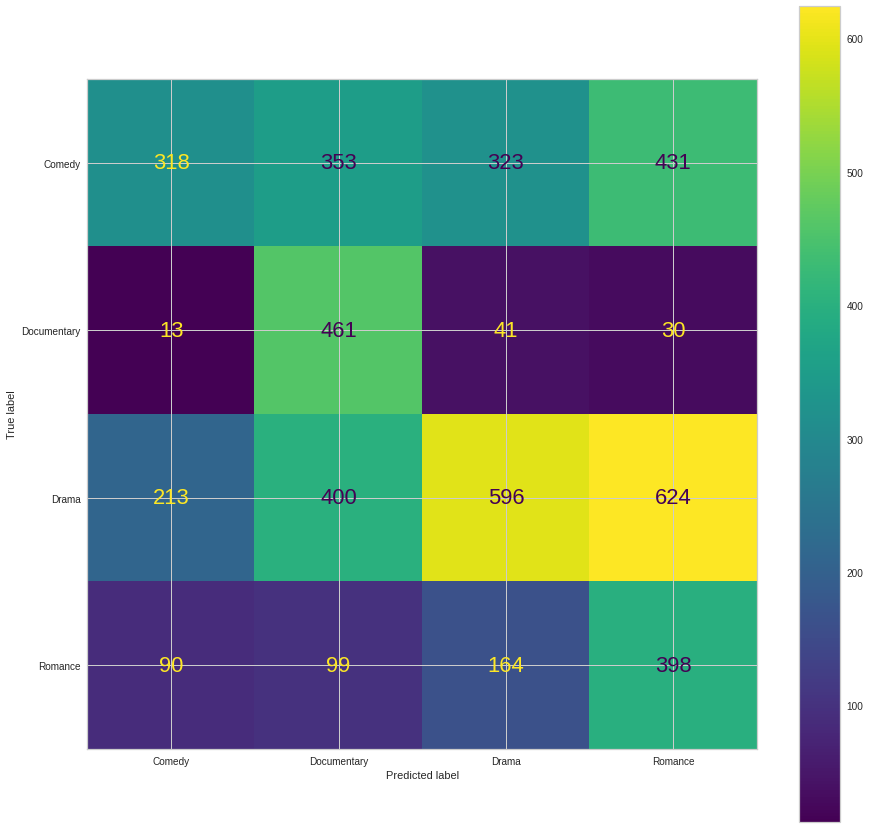

In [74]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(15, 15))

plot_confusion_matrix(model,X_test_stretch,y_test_stretch, ax=ax)


In [75]:
print(classification_report(y_test_stretch,model.predict(X_test_stretch)))

              precision    recall  f1-score   support

      Comedy       0.50      0.22      0.31      1425
 Documentary       0.35      0.85      0.50       545
       Drama       0.53      0.33      0.40      1833
     Romance       0.27      0.53      0.36       751

    accuracy                           0.39      4554
   macro avg       0.41      0.48      0.39      4554
weighted avg       0.46      0.39      0.38      4554



In [76]:
confusion_matrix(y_test_stretch,model.predict(X_test_stretch))

array([[318, 353, 323, 431],
       [ 13, 461,  41,  30],
       [213, 400, 596, 624],
       [ 90,  99, 164, 398]])

# SVM using multiOutputClassifier

In [59]:
multioutput_model = SVC(gamma="auto",kernel="rbf",C=0.1,probability=True)
multioutput_model = MultiOutputClassifier(multioutput_model, n_jobs=-1)

# edit to make it with the other features as well not the text data only
multioutput_model.fit(X_bow_train,np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))

MultiOutputClassifier(estimator=SVC(C=0.1, gamma='auto', probability=True),
                      n_jobs=-1)

In [60]:
multioutput_model.predict_proba(pd.DataFrame(X_bow_train[0]).T)

[array([[0.47450844, 0.52549156]]),
 array([[0.91337011, 0.08662989]]),
 array([[0.4326346, 0.5673654]]),
 array([[0.82277901, 0.17722099]])]

In [62]:
print("SVM multiOutputClassifier on train data score :",multioutput_model.score(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8")))

SVM multiOutputClassifier on train data score : 0.25655130262052106


In [63]:
print("SVM multiOutputClassifier on test data score :",multioutput_model.score(X_bow_test, np.array(X_test.loc[:,column_target[1]].to_list(),dtype="uint8")))

SVM multiOutputClassifier on test data score : 0.255117629086465


# OVR SVM


In [77]:
# using strectch varibale for one verses rest classifer
clf = OneVsRestClassifier(SVC(probability=True)).fit(X_train_stretch,y_train_stretch)


In [95]:
print("OVR SVM on train data score :",clf.score(X_train_stretch, y_train_stretch))

OVR SVM on train data score : 0.5379637160943523


In [96]:
print("OVR SVM on test data score :",clf.score(X_test_stretch, y_test_stretch))

OVR SVM on test data score : 0.33487044356609574


In [80]:
clf.predict_proba(pd.DataFrame(X_test_stretch[0]).T)

array([[0.27812804, 0.01357114, 0.37468092, 0.3336199 ]])

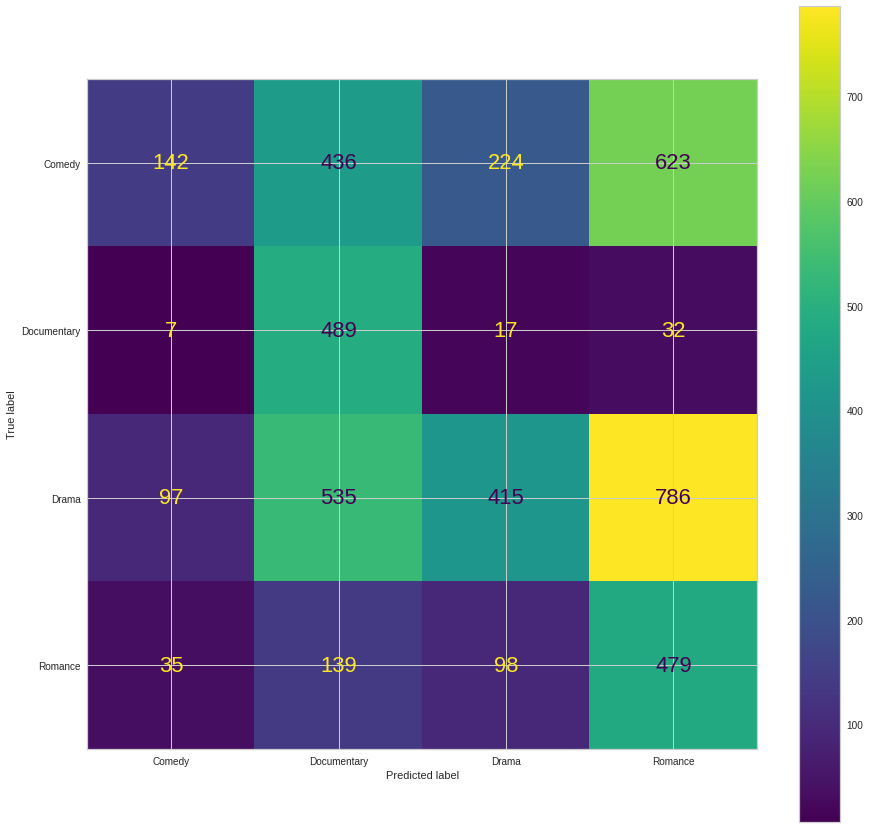

In [94]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(15, 15))

plot_confusion_matrix(clf,X_test_stretch,y_test_stretch, ax=ax)

# Gaussain NB

In [86]:
# class_mapping=['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
#        'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
#        'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
#        'TV Movie', 'Thriller', 'War', 'Western']

class_mapping=['Comedy', 'Documentary', 'Drama', 'Romance']

In [87]:
multioutput_model_nb = GaussianNB()
multioutput_model_nb = MultiOutputClassifier(multioutput_model_nb, n_jobs=-1)

multioutput_model_nb.fit(X_bow_train,np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))

MultiOutputClassifier(estimator=GaussianNB(), n_jobs=-1)

In [88]:
row_num_test=12
print("predicted Genres:")
for index,i in enumerate(multioutput_model_nb.predict_proba(pd.DataFrame(X_bow_train[row_num_test]).T)):
    if np.argmax(i[0])==1:
        print(class_mapping[index])

print("True labels:")
print(X_train.loc[row_num_test,column_target[1]])

print("Predicted probabilities:")
print([i[0][1] for i in multioutput_model_nb.predict_proba(pd.DataFrame(X_bow_train[row_num_test]).T)])


predicted Genres:
Drama
Romance
True labels:
[1, 0, 0, 0]
Predicted probabilities:
[0.07126492829328109, 0.010129935296359678, 0.9898003964309512, 0.9851889372703647]


In [89]:
print("Gaussain MultiOutputClassifier score on train data :",multioutput_model_nb.score(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8")))

Gaussain MultiOutputClassifier score on train data : 0.24791809916723967


In [90]:
print("Gaussain MultiOutputClassifier score on test data :",multioutput_model_nb.score(X_bow_test, np.array(X_test.loc[:,column_target[1]].to_list(),dtype="uint8")))

Gaussain MultiOutputClassifier score on test data : 0.24289642529789185


# Random Forest using MultiOutputClassifier

In [81]:
"""
ValueError: You appear to be using a legacy multi-label data representation. 
Sequence of sequences are no longer supported; use a binary array or sparse matrix instead
the MultiLabelBinarizer transformer can convert to this format.
"""
np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8")

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [135]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

#multi_target_forest.fit(svm_concat_numpy, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))
multi_target_forest.fit(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=0),
                      n_jobs=-1)

In [136]:
multi_target_forest.predict_proba(pd.DataFrame(X_bow_test[9]).T)

[array([[0.21, 0.79]]),
 array([[0.96, 0.04]]),
 array([[0.47, 0.53]]),
 array([[0.82, 0.18]])]

In [137]:
row_num_test=123
for index,i in enumerate(multi_target_forest.predict_proba(pd.DataFrame(X_bow_test[row_num_test]).T)):
    if np.argmax(i[0])==1:
        print(class_mapping[index])

print("True label:",X_test.loc[row_num_test,column_target[0]])  

Documentary
True label: ['Documentary']


In [138]:
print("Random Forest with multiOutputClassifer score on train data :",multi_target_forest.score(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="float32")))

Random Forest with multiOutputClassifer score on train data : 0.9993887997555199


In [139]:
print("Random Forest with multiOutputClassifer score on test data :",multi_target_forest.score(X_bow_test, np.array(X_test.loc[:,column_target[1]].to_list(),dtype="float32")))

Random Forest with multiOutputClassifer score on test data : 0.3516651390161931


# Clustering

# TF-IDF

In [ ]:
tfidf_params = dict(
    sublinear_tf=True,
    min_df=1,
    norm='l2',
    ngram_range=(1,1),
    stop_words='english'
    )

tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

tfidf_vectorizer.fit(X_train["text_concat"])
X_train_tfidf = tfidf_vectorizer.transform(X_train["text_concat"])

X_train_tfidf = pd.DataFrame(X_train_tfidf[:].todense(), columns=tfidf_vectorizer.get_feature_names())

## LDA

In [ ]:
docs = X_train["text_concat"].map(lambda x: word_tokenize(x)).tolist()
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
print(len(dictionary.items()))

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
def compute_coherence_values(limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    # Set training parameters.
    chunksize = 2000
    passes = 10
    iterations = 100
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token


    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every,
            random_state=RANDOM_STATE
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')#dictionary=dictionary
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
limit, start, step = len(unique_genres)+1, 2, 1
model_list, coherence_values = compute_coherence_values(limit=limit, start=start, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, "has Coherence Score", round(cv, 4))

In [ ]:
# Train LDA model on 8 topics as it's the best number from what we saw above

# Set training parameters.
num_topics = 8
chunksize = 2000
passes = 10
iterations = 100
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

LDA_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=RANDOM_STATE
)

top_topics = LDA_model.top_topics(corpus)


In [ ]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

In [ ]:
#pprint(top_topics)

In [ ]:
# Romance, Family, Documentary, History, Crime, Action, War, Western

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(LDA_model, corpus, dictionary=dictionary)
vis

In [ ]:
# Final model with 8 topics coherence score
coherence_model = CoherenceModel(model=LDA_model, corpus=corpus, coherence='u_mass')
print(f"LDA with {num_topics} topics coherence score:", coherence_model.get_coherence())

In [ ]:
LDA_model.show_topics(num_topics=num_topics, num_words=20)

In [ ]:
LDA_model.show_topic(topicid=0, topn=20)

In [ ]:
LDA_model.show_topic(topicid=1, topn=20)

In [ ]:
LDA_model.show_topic(topicid=2, topn=20)

In [ ]:
LDA_model.show_topic(topicid=3, topn=20)

In [ ]:
LDA_model.show_topic(topicid=4, topn=20)

In [ ]:
LDA_model.show_topic(topicid=5, topn=20)

In [ ]:
LDA_model.show_topic(topicid=6, topn=20)

In [ ]:
LDA_model.show_topic(topicid=7, topn=20)

In [ ]:
topics = ["Romance", "Family", "Documentary", "History", "Crime", "Action", "War", "Western"]
sunburst_df = pd.DataFrame()
for i in range(8):
    tmp_df = pd.DataFrame(LDA_model.show_topic(topicid=i, topn=10))
    tmp_df[1] = topics[i]
    sunburst_df = pd.concat([sunburst_df, tmp_df])
sunburst_df.head(20)

In [ ]:
# fig = px.sunburst(sunburst_df, path=[1, 0])
# fig.show()

In [ ]:
# pickle.dump(LDA_model, open("LDA_model.pkl", "wb"))

## LDA hyperparamter tuning  

In [ ]:
dictionary_param_tuning = Dictionary(docs)

# Filter out words that occur less than 0 documents, or more than 20% of the documents.
dictionary_param_tuning.filter_extremes(no_below=0, no_above=0.2)
print(len(dictionary_param_tuning.items()))

# Bag-of-words representation of the documents.
corpus_param_tuning = [dictionary_param_tuning.doc2bow(doc) for doc in docs]

In [ ]:
def compute_coherence_param_tuning(limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    # Set training parameters.
    chunksize_param_tuning = 2000
    passes_param_tuning = 10
    iterations_param_tuning = 100
    eval_every_param_tuning = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary_param_tuning[0]  # This is only to "load" the dictionary.
    id2word_param_tuning = dictionary_param_tuning.id2token


    coherence_values_param_tuning = []
    model_list_param_tuning = []
    for num_topics_param_tuning in range(start, limit, step):
        model_param_tuning = LdaModel(
            corpus=corpus_param_tuning,
            id2word=id2word_param_tuning,
            chunksize=chunksize_param_tuning,
            alpha='auto',
            eta='auto',
            iterations=iterations_param_tuning,
            num_topics=num_topics_param_tuning,
            passes=passes_param_tuning,
            eval_every=eval_every_param_tuning,
            random_state=RANDOM_STATE
        )
        model_list_param_tuning.append(model_param_tuning)
        coherencemodel_param_tuning = CoherenceModel(model=model_param_tuning, corpus=corpus_param_tuning, coherence='u_mass')#dictionary=dictionary
        coherence_values_param_tuning.append(coherencemodel_param_tuning.get_coherence())

    return model_list_param_tuning, coherence_values_param_tuning

In [ ]:
# Can take a long time to run.
limit_param_tuning, start_param_tuning, step_param_tuning = len(unique_genres) + 1, 2, 1
model_list_param_tuning, coherence_values_param_tuning = compute_coherence_param_tuning(limit=limit_param_tuning, start=start_param_tuning, step=step_param_tuning)

In [ ]:
# Show graph
x = range(start_param_tuning, limit_param_tuning, step_param_tuning)
plt.plot(x, coherence_values_param_tuning)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values_param_tuning):
    print("Number of Topics =", m, "has Coherence Score", round(cv, 4))

In [ ]:
# Train LDA model on 6 topics as it's the best number from what we saw above

# Set training parameters.
num_topics_param_tuning = 6
chunksize_param_tuning = 2000
passes_param_tuning = 10
iterations_param_tuning = 100
eval_every_param_tuning = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp_param_tuning = dictionary_param_tuning[0]  # This is only to "load" the dictionary.
id2word_param_tuning = dictionary_param_tuning.id2token

LDA_model_param_tuning = LdaModel(
    corpus=corpus_param_tuning,
    id2word=id2word_param_tuning,
    chunksize=chunksize_param_tuning,
    alpha='auto',
    eta='auto',
    iterations=iterations_param_tuning,
    num_topics=num_topics_param_tuning,
    passes=passes_param_tuning,
    eval_every=eval_every_param_tuning,
    random_state=RANDOM_STATE
)

top_topics_param_tuning = LDA_model_param_tuning.top_topics(corpus_param_tuning)


In [ ]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics. (param tuned)
avg_topic_coherence_param_tuning = sum([t[1] for t in top_topics_param_tuning]) / num_topics_param_tuning
print('Average topic coherence: %.4f.' % avg_topic_coherence_param_tuning)

In [ ]:
pprint(top_topics_param_tuning)

In [ ]:
pyLDAvis.enable_notebook()
vis_param_tuning = gensimvis.prepare(LDA_model_param_tuning, corpus_param_tuning, dictionary=dictionary_param_tuning)
vis_param_tuning

# K-Means - Ansary's edits


In [ ]:
# Init metrics
kmeans_silhouette_scores = []
kmeans_kappa_scores = []
kmeans_titles = []

# Encoding categorical data
y_encoded = X_train["genres_list_encoded"]

def kmeans_pca(n_clusters, features, title):
    pca = PCA(n_components=2, random_state=0)
    pca_features = pca.fit_transform(features)

    kmeans_model = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300, 
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    kmeans_model.fit(pca_features)
    y_pred = kmeans_model.predict(pca_features)
    
    print('Silhouette Score PCA:', silhouette_score(pca_features, y_pred, metric='euclidean'))
    kmeans_silhouette_scores.append(silhouette_score(pca_features, y_pred, metric='euclidean'))
    print('Kappa Score PCA:', cohen_kappa_score(y_pred, y_encoded))
    kmeans_kappa_scores.append(cohen_kappa_score(y_pred, y_encoded))
    kmeans_titles.append(title+' PCA')

    return kmeans_model, pca_features, y_pred

def kmeans_tsne(n_clusters, features, title):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_features = tsne.fit_transform(features)

    kmeans_model = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300, 
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    kmeans_model.fit(tsne_features)
    y_pred = kmeans_model.predict(tsne_features)

    print('Silhouette Score T-SNE:', silhouette_score(tsne_features, y_pred, metric='euclidean'))
    kmeans_silhouette_scores.append(silhouette_score(tsne_features, y_pred, metric='euclidean'))
    print('Kappa Score T-SNE:', cohen_kappa_score(y_pred, y_encoded))
    kmeans_kappa_scores.append(cohen_kappa_score(y_pred, y_encoded))
    kmeans_titles.append(title+' T-SNE')

    return kmeans_model, tsne_features, y_pred

def kmeans_svd(n_clusters, features, title):
    svd = TruncatedSVD(n_components=2, random_state=0)
    svd_features = svd.fit_transform(features)

    kmeans_model = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300, 
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    kmeans_model.fit(svd_features)
    y_pred = kmeans_model.predict(svd_features)

    print('Silhouette Score SVD:', silhouette_score(svd_features, y_pred, metric='euclidean'))
    kmeans_silhouette_scores.append(silhouette_score(svd_features, y_pred, metric='euclidean'))
    print('Kappa Score SVD:', cohen_kappa_score(y_pred, y_encoded))
    kmeans_kappa_scores.append(cohen_kappa_score(y_pred, y_encoded))
    kmeans_titles.append(title+' SVD')

    return kmeans_model, svd_features, y_pred

def kmeans_dimensionality_reduction(n_clusters, features, title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 4.8))
    fig.suptitle(title)

    tsne_kmeans_model, tsne_features , tsne_y_pred = kmeans_tsne(n_clusters, features, title)
    svd_kmeans_model, svd_features , svd_y_pred = kmeans_svd(n_clusters, features, title)

    axs[0].scatter(tsne_features[:,0], tsne_features[:, 1], s = 20, c = tsne_y_pred)
    axs[0].set_title('T-SNE')
    axs[1].scatter(svd_features[:,0], svd_features[:, 1], s = 20, c = svd_y_pred)
    axs[1].set_title('SVD')

In [ ]:
kmeans_dimensionality_reduction(6, X_bow_train_old, "KMeans BoW Dimensionality Reduction")

## Elbow Method with BoW

In [ ]:
# The Elbow Method
print("The Elbow Method")
# calculate distortion for a range of number of cluster
distortions_bow = []
for i in tqdm(range(1, len(unique_genres) + 1)):
    km_bow = KMeans(
        n_clusters=i,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    km_bow.fit(X_bow_train_old)
    distortions_bow.append(km_bow.inertia_)

# plot
plt.plot(range(1, len(unique_genres) + 1), distortions_bow, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, len(unique_genres) + 1))

visualizer.fit(X_bow_train_old)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## K-Means with BoW

In [ ]:
kmeans_bow = KMeans(
    n_clusters=visualizer.elbow_value_,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)
kmeans_bow.fit(X_bow_train_old)
y_pred_bow = kmeans_bow.fit_predict(X_bow_train_old)

centroids_bow = kmeans_bow.cluster_centers_.argsort()[:, ::-1]
terms_bow = count_vectorizer.get_feature_names()

# print(pd.DataFrame(y_pred_bow))
# print(centroids_bow)
# print(terms_bow)

# print('Silhouette Score BoW:', silhouette_score(X_bow[:].todense(), y_pred_bow, metric='euclidean'))
kmeans_silhouette_scores.append(silhouette_score(X_bow_train_old[:], y_pred_bow, metric='euclidean'))
# print('Kappa Score BoW:', cohen_kappa_score(y_pred_bow, y_encoded))
kmeans_kappa_scores.append(cohen_kappa_score(y_pred_bow, y_encoded))
kmeans_titles.append('KMeans with BoW')

In [ ]:
kmeans_silhouette_scores

In [ ]:
kmeans_kappa_scores

In [ ]:
# WordCloud
clusters = []
for i in range(visualizer.elbow_value_):
    cluster = []
    for ind in centroids_bow[i, :30]:
        cluster.append(terms_bow[ind])
    clusters.append(' '.join(str(''.join(str(x) for x in v)) for v in cluster))

for i in range(len(clusters)):
    cluster_words = "".join(str(x) for x in clusters[i])
    wordcloud = WordCloud(max_font_size = 60).generate(cluster_words)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

## K-Means with TF-IDF

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model_tfidf = KMeans(random_state=0)
visualizer_tdidf = KElbowVisualizer(model_tfidf, k=(2, len(unique_genres) + 1))

visualizer_tdidf.fit(X_train_tfidf)        # Fit the data to the visualizer
visualizer_tdidf.show()        # Finalize and render the figure

In [ ]:
if visualizer_tdidf.elbow_value_ != None:
  kmeans_tfidf = KMeans(
      n_clusters=visualizer_tdidf.elbow_value_,
      init='k-means++',
      n_init=10,
      max_iter=300, 
      tol=1e-04,
      random_state=RANDOM_STATE
  )
  kmeans_tfidf.fit(X_tfidf)
  y_pred_tfidf = kmeans_tfidf.fit_predict(X_tfidf)

  centroids_tfidf = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]
  terms_tfidf = tfidf_vectorizer.get_feature_names()

  print(pd.DataFrame(y_pred_tfidf))
  print(centroids_tfidf)
  print(terms_tfidf)

  # print('Silhouette Score TF-IDF:', silhouette_score(X_tfidf[:].todense(), y_pred_tfidf, metric='euclidean'))
  kmeans_silhouette_scores.append(silhouette_score(X_tfidf[:], y_pred_tfidf, metric='euclidean'))
  # print('Kappa Score TF-IDF:', cohen_kappa_score(y_pred_tfidf, y_encoded))
  kmeans_kappa_scores.append(cohen_kappa_score(y_pred_tfidf, y_encoded))
  kmeans_titles.append('KMeans with TF-IDF')


  print(kmeans_silhouette_scores)
  print(kmeans_kappa_scores)

In [ ]:
if visualizer_tdidf.elbow_value_ != None:
  # WordCloud
  clusters = []
  for i in range(visualizer_tdidf.elbow_value_):
      cluster = []
      for ind in centroids_tfidf[i, :30]:
          cluster.append(terms_tfidf[ind])
      clusters.append(' '.join(str(''.join(str(x) for x in v)) for v in cluster))

  for i in range(len(clusters)):
      cluster_words = "".join(str(x) for x in clusters[i])
      wordcloud = WordCloud(max_font_size = 60).generate(cluster_words)
      plt.figure(figsize=(8,6))
      plt.imshow(wordcloud, interpolation = "bilinear")
      plt.axis("off")
      plt.show()

## K-Means with LDA

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# transforming LDA model output to numpy array so we can use it in our model
topics_sparse_matrix = gensim.matutils.corpus2csc(LDA_model[corpus])
topics_numpy_array = topics_sparse_matrix.T.toarray()

# Instantiate the clustering model and visualizer
model_lda = KMeans(random_state=0)
visualizer_lda = KElbowVisualizer(model_lda, k=(2, len(unique_genres) + 1))

visualizer_lda.fit(topics_numpy_array)        # Fit the data to the visualizer
visualizer_lda.show()        # Finalize and render the figure

In [ ]:
# transforming LDA model output to numpy array so we can use it in our model
topics_sparse_matrix = gensim.matutils.corpus2csc(LDA_model[corpus])
topics_numpy_array = topics_sparse_matrix.T.toarray()

# start modeling and training
kmeans_lda = KMeans(
    n_clusters=6,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)

y_pred_lda = kmeans_lda.fit_predict(topics_numpy_array)

centroids_lda = kmeans_lda.cluster_centers_.argsort()[:, ::-1]
terms_lda = count_vectorizer.get_feature_names()
    
print(pd.DataFrame(y_pred_lda))
print(centroids_lda)
print(terms_lda)

# print('Silhouette Score LDA:', silhouette_score(topics_numpy_array, y_pred_lda, metric='euclidean'))
kmeans_silhouette_scores.append(silhouette_score(topics_numpy_array, y_pred_lda, metric='euclidean'))
# print('Kappa Score LDA:', cohen_kappa_score(y_pred_lda, y_encoded))
kmeans_kappa_scores.append(cohen_kappa_score(y_pred_lda, y_encoded))
kmeans_titles.append('KMeans with LDA')

## K-Means with LDA

In [ ]:
# start modeling and training
kmeans_lda_param_tuning = KMeans(
    n_clusters=visualizer_lda.elbow_value_,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)

y_pred_lda_param_tuning = kmeans_lda_param_tuning.fit_predict(topics_numpy_array)

centroids_lda_param_tuning = kmeans_lda_param_tuning.cluster_centers_.argsort()[:, ::-1]
terms_lda_param_tuning = count_vectorizer.get_feature_names()
    
# print(pd.DataFrame(y_pred_lda_param_tuning))
# print(centroids_lda_param_tuning)
# print(terms_lda_param_tuning)

# print('Silhouette Score LDA 5 Clusters:', silhouette_score(topics_numpy_array, y_pred_lda_param_tuning, metric='euclidean'))
kmeans_silhouette_scores.append(silhouette_score(topics_numpy_array, y_pred_lda, metric='euclidean'))
# print('Kappa Score LDA 5 Clusters:', cohen_kappa_score(y_pred_lda_param_tuning, y_encoded))
kmeans_kappa_scores.append(cohen_kappa_score(y_pred_lda, y_encoded))
kmeans_titles.append('KMeans with LDA 5 Clusters')

## K-Means Evaluation

In [ ]:
kmeans_indices = np.arange(len(kmeans_silhouette_scores))

plt.bar(kmeans_indices, kmeans_silhouette_scores, width = 0.3, color='r', align = 'center', label = 'K-Means Silhouette')
plt.bar(kmeans_indices+0.3, kmeans_kappa_scores, width = 0.3, color='g', align = 'center', label = 'K-Means Kappa')
 
plt.xticks(kmeans_indices+0.3)

plt.xticks(kmeans_indices, kmeans_titles, rotation='vertical')
plt.legend()

# Item-based CF


In [ ]:
# Recomendation using only genre and vote_average
# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1 0.4]


new_x=[]
for x,y in zip(X_train["genre_hot_encoded"], X_train["vote_average"]):
    genres_votes=[]

    genres = x
    genres_votes.extend(genres)
    genres_votes.extend([round(float(y)/10,3)])
    new_x.append(genres_votes)

In [ ]:
print(new_x[1])

In [ ]:
corr_mat = np.corrcoef(new_x)
corr_mat.shape

In [ ]:
X_train["original_title"].head()

In [ ]:
X_train.columns

In [ ]:
print(X_train[X_train["original_title"]=="The Dead Room"][["genres_list","vote_average","vote_count"]])
print(X_train[X_train["original_title"]=="Greystone Park"][["genres_list","vote_average","vote_count"]])

In [ ]:
col_idx = X_train.index[X_train["original_title"]=="The Shadow Men"].tolist()
corr_specific = corr_mat[col_idx].T[:,0]
# print(corr_specific.T.shape)

tmp=pd.DataFrame({'corr_specific':corr_specific, 'Movies': X_train['original_title']})\
.sort_values('corr_specific', ascending=False)\
.head(10)

print(tmp)
tmp2=pd.DataFrame()
for i in tmp["Movies"].to_list():
  tmp2=tmp2.append(X_train[X_train["original_title"]==i][["genres_list","vote_average"]])
print(tmp2)


# Userbased Collaborative Filtering  - New dataframes initializations
Dont run!!!!!


In [ ]:
userRatings= pd.read_csv("ratings_small.csv")

In [ ]:
userRatings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
userRatings = userRatings.drop(['timestamp'], axis=1)
userRatings.rename(columns={'userId': 'userID', 'movieId': 'itemID'}, inplace=True)

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(userRatings[['userID', 'itemID', 'rating']], reader)

In [ ]:
data.shape

In [ ]:
# benchmark = []

# algorithm  = SVDpp()
# results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
# tmp = pd.DataFrame.from_dict(results).mean(axis=0)
# tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
# benchmark.append(tmp)

In [ ]:
# userBased_benchmark = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
# userBased_benchmark

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.892454,301.569399,11.24787


In [ ]:
results

{'test_rmse': array([0.89126108, 0.89718035, 0.88892126]), 'fit_time': (307.96939969062805, 298.24126720428467, 298.49752926826477), 'test_time': (11.665069103240967, 11.197849988937378, 10.880691051483154)}

In [ ]:
df= pd.read_csv(movies_metadata , usecols=["id", "original_title","genres","vote_average"])
links= pd.read_csv("links.csv",usecols=["movieId"])

In [ ]:
final_genre_list=[]
for i in df["genres"]:
    tmp=[]
    for j in eval(i):
        tmp.append(j["name"])
    final_genre_list.append(tmp)
df["genres"] = final_genre_list
df["id"]=links["movieId"]
df.rename(columns={"genres":"genres_list"}, inplace=True)

In [ ]:
trainset = data.build_full_trainset() 
algo = SVDpp()
algo.fit(trainset)
testset = trainset.build_anti_testset()

predictions = algo.test(testset)

KeyboardInterrupt: ignored

In [ ]:
def get_all_predictions(predictions, topN, user_id):
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:topN]
    tmp = pd.DataFrame.from_dict(top_n)
    tmp_transpose = tmp.transpose()
    
    results = tmp_transpose.loc[user_id]
    recommended_movie_ids=[]
    for x in range(0, topN):
        recommended_movie_ids.append(results[x][0])
    movies_recommended = df[df["id"].isin(recommended_movie_ids)].loc[:,["original_title","genres_list"]]
    
    return movies_recommended


In [ ]:
userID = 1
topN = 5
recommendations=get_all_predictions(predictions, topN, userID)
recommendations

In [ ]:
userXRatings = userRatings[userRatings["userID"]==userID].sort_values("rating", ascending = False)
original_ratings =df[df["id"].isin(userXRatings["itemID"])].loc[:,["original_title","genres_list"]]
original_ratings